In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re


In [93]:
# Function to plot a bar chart from a dictionary
def bar_chart(data_dict, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(8, 6))
    plt.bar(data_dict.keys(), data_dict.values(), color='steelblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(list(data_dict.keys()))
    plt.show()

def preview_df(df, name="", num_rows=3):
    print( "-" * 40 )
    print( f"DataFrame Preview: {name}" )
    print( f"DataFrame Shape: {df.shape}" )
    print( f"DataFrame Columns: {df.columns.tolist()}" )
    display(df.sample(num_rows))


# Carga de Datos

In [94]:

data_reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
data_orders = pd.read_csv('../data/olist_orders_dataset.csv')
data_customers = pd.read_csv('../data/olist_customers_dataset.csv')
data_order_items = pd.read_csv('../data/olist_order_items_dataset.csv')
data_sellers = pd.read_csv('../data/olist_sellers_dataset.csv')
data_products = pd.read_csv('../data/olist_products_dataset.csv')
data_categories = pd.read_csv('../data/product_category_name_translation.csv')

preview_df(data_reviews, name="Reviews Dataset")
preview_df(data_orders, name="Orders Dataset")
preview_df(data_customers, name="Customers Dataset")
preview_df(data_order_items, name="Order Items Dataset")
preview_df(data_sellers, name="Sellers Dataset")
preview_df(data_products, name="Products Dataset")
preview_df(data_categories, name="Categories Dataset")


----------------------------------------
DataFrame Preview: Reviews Dataset
DataFrame Shape: (99224, 7)
DataFrame Columns: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
37790,10eb0f05b4d0daab185375cead834a37,0f12cbc174814d0b137bb00d87bea3ee,5,NaN,NaN,2017-07-08 00:00:00,2017-07-08 23:53:25
69216,a91f037fa1e04970cb0d5f13ecc0fd29,34fc07c730847e0b63265acd9b7be198,5,NaN,NaN,2018-05-11 00:00:00,2018-05-12 01:40:27
23954,2f9aeb19f47d00c832ecd86ac5ee99ef,7e284574be8d83b004427c79e11a1a99,5,NaN,Excelente,2017-09-01 00:00:00,2017-09-02 10:40:15


----------------------------------------
DataFrame Preview: Orders Dataset
DataFrame Shape: (99441, 8)
DataFrame Columns: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2201,fa9832914e7afeaf41fc9fbda5ca335f,b71fef05a7e2a9b61b51d713c151cf6c,delivered,2018-02-14 20:48:53,2018-02-14 21:07:27,2018-02-15 19:13:10,2018-02-27 13:35:41,2018-03-06 00:00:00
42011,1ab115802be10ff22d8907afe81ba5b0,ba43fce88d51851ce5448562ea461800,delivered,2017-09-28 12:59:00,2017-09-30 02:28:36,2017-10-04 17:17:51,2017-10-10 23:32:51,2017-10-23 00:00:00
9152,976c9f4a0b6d3158f01dcd00b625756c,4c2ce84551ecffe29ecdc34876746c5d,delivered,2018-05-10 11:28:36,2018-05-10 11:51:48,2018-05-10 15:17:00,2018-05-16 12:53:08,2018-05-30 00:00:00


----------------------------------------
DataFrame Preview: Customers Dataset
DataFrame Shape: (99441, 5)
DataFrame Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
94489,416e59b08933168cebeda1fc262a76eb,0d51034f3d6811dfd6c73b6b0f328a80,5588,sao paulo,SP
93580,1a13ae9c45155eae252b87ca747618d6,aa158429a498b4afb75488e56032f193,93214,sapucaia do sul,RS
21557,6cd7106899e59a1fbd0622d5f1efedf4,6360ff9a3d58800ba0b03b1c6c290d92,11730,mongagua,SP


----------------------------------------
DataFrame Preview: Order Items Dataset
DataFrame Shape: (112650, 7)
DataFrame Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
30042,443a73a22cd4e0078a47c275b358b786,2,90c3564fa89e67d5e1b4898dd43cebc9,2c9e548be18521d1c43cde1c582c6de8,2018-05-18 12:31:08,25.90,18.23
33756,4c6e24a5fceacbcf444cdb5141ec1688,1,e919bdbe0314f5cef7d86707f9d89c1e,df47da4ae86fa4db890d05aaf24e21d8,2018-08-13 03:44:53,58.90,16.60
63651,91501d5292dbe67f25d3c8867cd67f44,1,2acce4db469045e8f9a863028abce19d,92eb0f42c21942b6552362b9b114707d,2017-10-18 13:25:52,17.99,16.11


----------------------------------------
DataFrame Preview: Sellers Dataset
DataFrame Shape: (3095, 4)
DataFrame Columns: ['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']


,seller_id,seller_zip_code_prefix,seller_city,seller_state
2392,5b67882648febfb6e1225e6ad7164f6b,87502,umuarama,PR
1487,cf654707ed6a99f112c7ec3d6f314b8b,4615,sao paulo,SP
1518,d58d521f3789def2e7a22715e0badd93,3643,sao paulo,SP


----------------------------------------
DataFrame Preview: Products Dataset
DataFrame Shape: (32951, 9)
DataFrame Columns: ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
15373,5a3f2f6e363dcc2277ba8df88f3a078c,utilidades_domesticas,39.0,530.0,1.0,10700.0,26.0,87.0,48.0
20995,389e3d8b3dba6f6166e1e0f4e242e11e,papelaria,54.0,529.0,1.0,6350.0,48.0,24.0,33.0
29084,f6605392877b41d225dd146d2cf116b5,ferramentas_jardim,56.0,1182.0,1.0,550.0,17.0,17.0,17.0


----------------------------------------
DataFrame Preview: Categories Dataset
DataFrame Shape: (71, 2)
DataFrame Columns: ['product_category_name', 'product_category_name_english']


,product_category_name,product_category_name_english
9,relogios_presentes,watches_gifts
65,dvds_blu_ray,dvds_blu_ray
15,telefonia_fixa,fixed_telephony


In [95]:
# Merge datasets to create a comprehensive "Maestro" dataset
df_maestro = data_reviews.merge(data_orders, on='order_id', how='inner')
# Merge with order_items
df_maestro = df_maestro.merge(data_order_items, on='order_id', how='inner')
# If no date fill with a default value (e.g., 1970-01-01) to avoid issues with date calculations
df_maestro['order_delivered_customer_date'] = pd.to_datetime(df_maestro['order_delivered_customer_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_estimated_delivery_date'] = pd.to_datetime(df_maestro['order_estimated_delivery_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_delivered_carrier_date'] = pd.to_datetime(df_maestro['order_delivered_carrier_date']).fillna(pd.Timestamp('1970-01-01'))
df_maestro['order_purchase_timestamp'] = pd.to_datetime(df_maestro['order_purchase_timestamp']).fillna(pd.Timestamp('1970-01-01'))

# Calculate delivery delta in days
df_maestro['delivery_delta_days'] = (df_maestro['order_delivered_customer_date'] - 
                                    df_maestro['order_estimated_delivery_date']).dt.days
# Calculate seller dispatch days 
df_maestro['seller_dispatch_days'] = (df_maestro['order_delivered_carrier_date'] - 
                                   df_maestro['order_purchase_timestamp']).dt.days
# Calculate carrier transit days
df_maestro['carrier_transit_days'] = (df_maestro['order_delivered_customer_date'] - 
                                   df_maestro['order_delivered_carrier_date']).dt.days  

# Merge review_comment_message and review_comment_title into a single column for analysis
df_maestro['full_text'] = df_maestro['review_comment_title'].fillna('') + ' ' + df_maestro['review_comment_message'].fillna('')

preview_df(df_maestro[['order_id','full_text','review_score','order_delivered_customer_date','delivery_delta_days','seller_dispatch_days','carrier_transit_days']],num_rows=10,name="Maestro Dataset")
df_maestro.info()

----------------------------------------
DataFrame Preview: Maestro Dataset
DataFrame Shape: (112372, 7)
DataFrame Columns: ['order_id', 'full_text', 'review_score', 'order_delivered_customer_date', 'delivery_delta_days', 'seller_dispatch_days', 'carrier_transit_days']


,order_id,full_text,review_score,order_delivered_customer_date,delivery_delta_days,seller_dispatch_days,carrier_transit_days
53092,ffd5e80bfdaf69504efd7562a3d522dd,,5,2017-08-23 14:51:52,-12,0,0
64456,2a81ea52abe140811e40a9f72d4fab01,,5,2018-05-10 00:12:00,-26,2,7
42624,ef9436d5d8ad55bb0f9dc670d8391ee8,chegou bem antes do informado.,5,2017-12-09 14:08:58,-18,2,7
39931,2155f2ca8e14d8b4136fdc215fb53bb7,Ótimo,5,2018-08-17 15:54:32,-5,5,2
96548,bae6f9f2cc261de0a62c483184fde7f4,,2,2018-03-08 18:13:23,0,5,14
34192,8a03e73a80b701470a167fc0291836b7,Produto de acordo com o descrito! \r\nEntregu...,5,2018-04-13 18:06:54,-12,3,3
57662,11642b906362f0d80a1228e1fa45a18e,,5,2018-03-19 23:32:05,3,2,20
14065,82598d1412ae8a6ab0939b8d0d12e16d,,1,2018-02-23 01:03:42,14,8,28
26719,b6238a76012ed88aec12a5a12f9f5795,"Recomendo Entrega antes da data prevista, ador...",5,2018-07-11 19:37:43,-12,0,1
80320,e84b5f26050a7928a7541078a7947e05,O produto que recebi não é o que mostra na im...,3,2018-04-09 21:50:48,-9,8,5


<class 'pandas.DataFrame'>
RangeIndex: 112372 entries, 0 to 112371
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   review_id                      112372 non-null  str           
 1   order_id                       112372 non-null  str           
 2   review_score                   112372 non-null  int64         
 3   review_comment_title           13434 non-null   str           
 4   review_comment_message         47642 non-null   str           
 5   review_creation_date           112372 non-null  str           
 6   review_answer_timestamp        112372 non-null  str           
 7   customer_id                    112372 non-null  str           
 8   order_status                   112372 non-null  str           
 9   order_purchase_timestamp       112372 non-null  datetime64[us]
 10  order_approved_at              112357 non-null  str           
 11  order_deliv

In [96]:
df_analysis = df_maestro[df_maestro['review_comment_message'].notna()].copy()

# original reviews
print( f"Original reviews: {len(data_reviews)}")
# non null reviews
print( f"Total reviews: {len(df_analysis)}" )
# percentage of non-null reviews
print(f"Percentage of non-null reviews: {len(df_analysis)/len(data_reviews)*100:.2f}%")


Original reviews: 99224
Total reviews: 47642
Percentage of non-null reviews: 48.01%


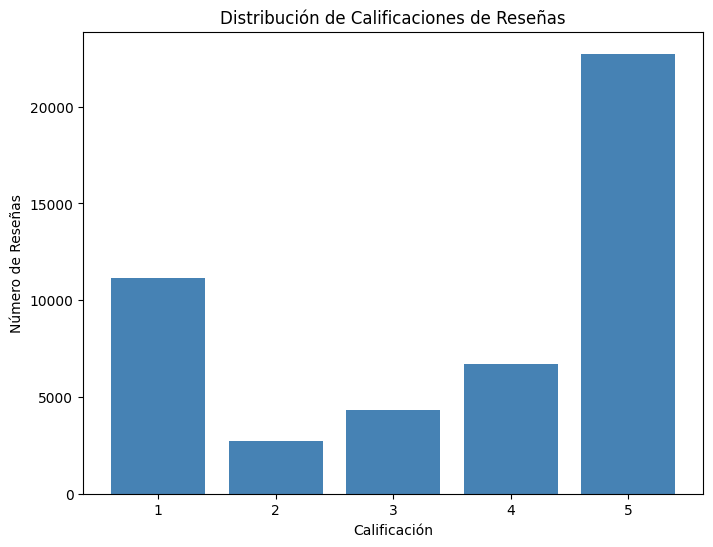

In [97]:

bar_chart(
    df_analysis['review_score'].value_counts().to_dict(),
    title='Distribución de Calificaciones de Reseñas',
    xlabel='Calificación',
    ylabel='Número de Reseñas'
)

In [98]:
def calculate_stats_per_row (data, column):
    data[column] = data[column].fillna('')
    
    # Cantidad de caracteres
    data['char_count'] = data[column].str.len()
    
    # Cantidad de palabras
    data['word_count'] = data[column].apply(lambda x: len(x.split()))
    
    # Cantidad de oraciones (aproximado por puntos, signos de exclamación e interrogación)
    data['sentence_count'] = data[column].apply(
        lambda x: max(1, len(re.split(r'[.!?]+', x.strip())) - 1)
    )
    
    # Longitud promedio de palabras
    data['avg_word_length'] = data[column].apply(
        lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0
    )
    
    # Palabras por oración
    data['words_per_sentence'] = data['word_count'] / data['sentence_count']
    
    # Palabras únicas
    data['unique_words_count'] = data[column].apply(
        lambda x: len(set(x.lower().split()))
    )
    # Signos de exclamación
    data['exclamation_count'] = data[column].str.count('!')
    
    # Signos de interrogación
    data['question_count'] = data[column].str.count(r'\?')
    
    # Comas
    data['comma_count'] = data[column].str.count(',')
    
    # Puntos
    data['period_count'] = data[column].str.count(r'\.')
    return data

df_analysis['full_text'] = df_analysis['review_comment_title'].fillna('') + '' + df_analysis['review_comment_message'].fillna('')

calculate_stats_per_row(df_analysis, 'full_text')


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,char_count,word_count,sentence_count,avg_word_length,words_per_sentence,unique_words_count,exclamation_count,question_count,comma_count,period_count
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,37,6,1,5.333333,6.000000,6,0,0,0,1
5,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,5986b333ca0d44534a156a52a8e33a83,delivered,2018-02-10 10:59:03,...,100,15,1,5.733333,15.000000,14,0,0,0,0
13,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,a5224bdc7685fd39cd7a23404415493d,delivered,2018-05-14 10:29:02,...,183,30,2,5.133333,15.000000,25,0,0,0,4
20,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,8ebbeb09e94d1e789142983f73faa9cd,delivered,2018-02-12 16:07:34,...,45,7,2,5.285714,3.500000,7,0,0,1,4
24,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,659ded3e9b43aaf51cf9586d03033b46,delivered,2018-05-18 18:20:45,...,71,10,1,6.200000,10.000000,10,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112354,98fffa80dc9acbde7388bef1600f3b15,d398e9c82363c12527f71801bf0e6100,4,NaN,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00,2017-11-30 15:52:51,2bf76a48c3be55124221fd0657705a5d,delivered,2017-11-19 11:56:42,...,58,10,1,4.900000,10.000000,10,1,0,0,0
112357,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,5,NaN,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23,69f07139131eb94ecb8e5b5d601b1f7a,delivered,2018-01-31 23:37:38,...,91,13,3,6.000000,4.333333,13,1,0,0,2
112363,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,3,NaN,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06,f1622b5b691cbc9c39f10ff359043335,delivered,2018-05-14 17:00:31,...,125,25,1,4.040000,25.000000,22,0,0,2,1
112369,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,2018-03-18 09:52:19,...,67,9,2,6.555556,4.500000,8,1,0,1,1


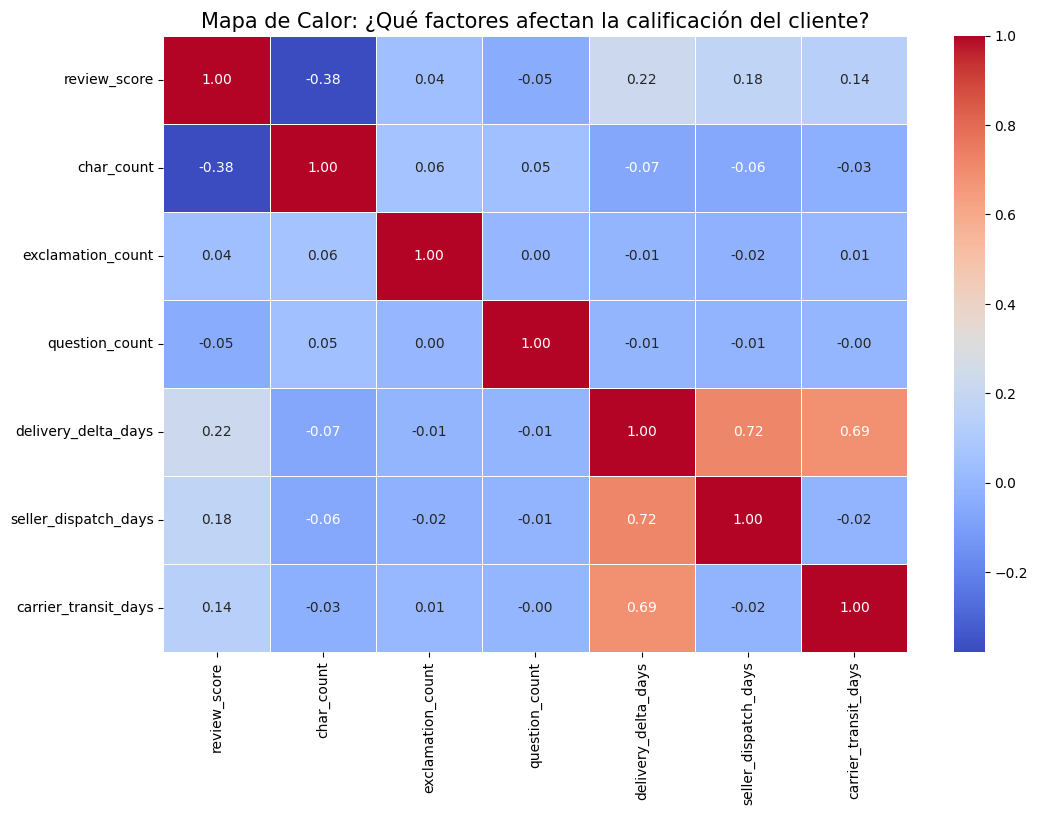

In [99]:
cols_para_correlacion = [
    'review_score', 
    'char_count', 
    'exclamation_count', 
    'question_count',
    'delivery_delta_days', 
    'seller_dispatch_days', 
    'carrier_transit_days'
]

# 2. Calculamos la matriz de correlación
corr_matrix = df_analysis[cols_para_correlacion].corr()

# 3. Graficamos
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Calor: ¿Qué factores afectan la calificación del cliente?', fontsize=15)
plt.show()

In [110]:
def calculate_general_stats(data,column):
    texts = data[column].fillna('')
    
    # Concatenar todo el texto
    all_text = ' '.join(texts)
    all_words = all_text.lower().split()
    stats = {
        # Básicas
        'total_texts': len(data),
        'total_words': len(all_words),
        'vocabulary_size': len(set(all_words)),
        
        # Promedios
        'mean_word_count': data['word_count'].mean(),
        'median_word_count': data['word_count'].median(),
        'std_word_count': data['word_count'].std(),
        'min_word_count': data['word_count'].min(),
        'max_word_count': data['word_count'].max(),
        
        # Calidad
        'empty_count': (data[column] == '').sum(),
        'duplicate_count': data[column].duplicated().sum(),
        'duplicate_ratio': data[column].duplicated().sum() / len(data),
        'very_short_texts': (data['char_count'] < 10).sum(),
        'very_long_texts': (data['char_count'] > 1000).sum(),
        
    }
    return stats

calculate_general_stats(data_reviews, 'full_text')

{'total_texts': 99224,
 'total_words': 500234,
 'vocabulary_size': 30483,
 'mean_word_count': np.float64(5.041461743126663),
 'median_word_count': np.float64(0.0),
 'std_word_count': np.float64(8.604776697751602),
 'min_word_count': np.int64(0),
 'max_word_count': np.int64(48),
 'empty_count': np.int64(0),
 'duplicate_count': np.int64(61301),
 'duplicate_ratio': np.float64(0.6178041602838023),
 'very_short_texts': np.int64(58965),
 'very_long_texts': np.int64(0)}